# Задача классификации рукописных арабских цифр
## _Использование свёрточного автоэнкодера и генератора изображений_

In [1]:
import numpy
import time
import matplotlib.pyplot as plt

import sklearn
import sklearn.datasets # load_digits()
import sklearn.cluster # KMeans
import sklearn.metrics

import math

%matplotlib inline

## 1. Загрузка данных

In [2]:
digits = sklearn.datasets.load_digits()

In [3]:
digits['data']

array([[ 0.,  0.,  5., ...,  0.,  0.,  0.],
       [ 0.,  0.,  0., ..., 10.,  0.,  0.],
       [ 0.,  0.,  0., ..., 16.,  9.,  0.],
       ...,
       [ 0.,  0.,  1., ...,  6.,  0.,  0.],
       [ 0.,  0.,  2., ..., 12.,  0.,  0.],
       [ 0.,  0., 10., ..., 12.,  1.,  0.]])

In [4]:
len(digits['data']), len(digits['data'][0])

(1797, 64)

Посмотрим минимальные и максимальные значение пикселей:

In [5]:
min([min(v) for v in digits['data']]), max([max(v) for v in digits['data']])

(0.0, 16.0)

А также метки и их количество:

In [6]:
digits['target'], sorted(set(digits['target']))

(array([0, 1, 2, ..., 8, 9, 8]), [0, 1, 2, 3, 4, 5, 6, 7, 8, 9])

In [7]:
len(digits['target'])

1797

__Итак, в размеченном наборе данных всего 1797 цифр, каждая представлена одномерным массивом из 64 элементов (8x8 пикселей)__.

Так они выглядят (первые 50 изображений).

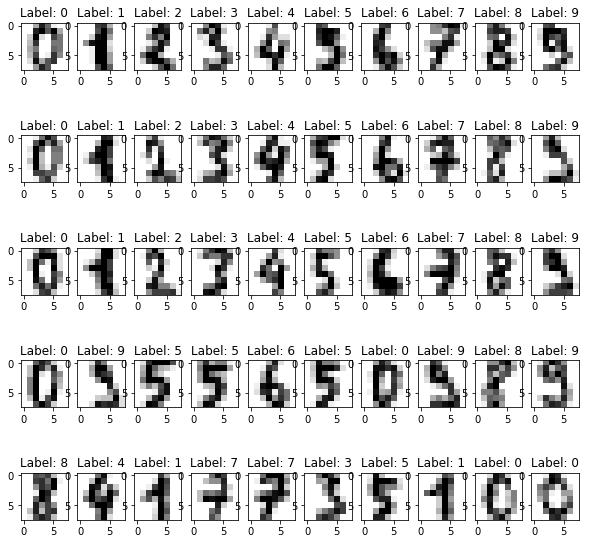

In [8]:
plt.figure(figsize=(10,10))
for i in range(50):
    plt.subplot(5, 10, i + 1)
    plt.imshow(digits.images[i], cmap=plt.cm.gray_r, interpolation='nearest')
    plt.title(f'Label: {digits["target"][i]}')

## 2. Используемые методы (немного матана)

### Алгоритм K-Means:
K-Means это один из самых используемых алгоритмов кластеризации.
По данным и числу кластеров $k$, он итеративно вычисляет распределение объектов по k кластерам {$S_1, \dots, S_k$} и центры кластеров, минимизируя суммарное расстояние от центров кластеров до объектов, которые к ним относятся:

$$\sum\limits_{i=1}^{k} \sum\limits_{j:x_j\in S_i}^n\|x_j-m_i\|^2$$
Где $k$ число кластеров, $n$ число объектов, $S_i$ это $i$-ый кластер с центром в  $m_i$, $x_j$ это $j$-ый объект.

### Автоэнкодеры:

Автоэнкодеры — это нейронные сети прямого распространения, которые восстанавливают входной сигнал на выходе. Внутри у них имеется скрытый слой, который представляет собой код, описывающий модель. Автоэнкодеры конструируются таким образом, чтобы не иметь возможность точно скопировать вход на выходе.

Автоэнкодеры состоят из двух частей: энкодера $g$ и декодера $f$. Энкодер переводит входной сигнал в его представление (код): $h=g(x)$, а декодер восстанавливает сигнал по его коду: $x=f(h)$.

Автоэнкодер, изменяя $f$ и $g$, стремится выучить тождественную функцию $x=f(g(x))$, минимизируя какой-то функционал ошибки: $L(x, f(g(x))$.

1. https://blog.keras.io/building-autoencoders-in-keras.html
1. https://habr.com/post/331382/
1. https://keras.io/layers/convolutional/#conv2d

![Autoencoder](./autoencoder.png)

https://blog.keras.io/building-autoencoders-in-keras.html

## 3. Подготовим данные - тренировочные и тестовые

In [17]:
from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test = train_test_split(digits['data'], digits['target'], train_size=0.8)

c:\users\stas\envs\data_science\lib\site-packages\sklearn\model_selection\_split.py:2026: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


In [18]:
x_train = x_train.astype('float32') / 16.0
x_test = x_test.astype('float32') / 16.0

x_train = x_train.reshape((-1, 8, 8, 1))
x_test = x_test.reshape((-1, 8, 8, 1))

In [19]:
from keras.utils import to_categorical

y_train = to_categorical(y_train.astype('int'))
y_test = to_categorical(y_test.astype('int'))

y_train.ndim, y_train.shape

(2, (1437, 10))

In [21]:
from keras.preprocessing.image import ImageDataGenerator

fotogen = ImageDataGenerator(width_shift_range=1, height_shift_range=1, shear_range=1,
                             zoom_range=0.2, horizontal_flip=False, fill_mode='nearest')
fotogen.fit(x_train)

## 4. Свёрточный автоэнкодер

In [117]:
from keras.layers import Input, Dense, Conv2D, MaxPooling2D, UpSampling2D
from keras.layers import Dropout
from keras.layers import Flatten, Reshape
from keras.models import Model
from keras import regularizers

In [194]:
input_image = Input(shape=(8, 8, 1))

step = Conv2D(16, (3, 3), activation='relu', padding='same')(input_image)
step = MaxPooling2D((2, 2), padding='same')(step)
step = Conv2D(8, (3, 3), activation='relu', padding='same')(step)

encoded = Conv2D(1, (2, 2), activation='relu', padding='same', kernel_regularizer=regularizers.l1_l2(0.001))(step)

step = Conv2D(8, (3, 3), activation='relu', padding='same')(encoded)
step = Conv2D(16, (3, 3), activation='relu', padding='same')(step)
step = UpSampling2D((2, 2))(step)

decoded = Conv2D(1, (3, 3), activation='sigmoid', padding='same')(step)

autoencoder = Model(input_image, decoded)

encoder = Model(input_image, encoded)

autoencoder.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
autoencoder.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_93 (InputLayer)        (None, 8, 8, 1)           0         
_________________________________________________________________
conv2d_430 (Conv2D)          (None, 8, 8, 16)          160       
_________________________________________________________________
max_pooling2d_144 (MaxPoolin (None, 4, 4, 16)          0         
_________________________________________________________________
conv2d_431 (Conv2D)          (None, 4, 4, 8)           1160      
_________________________________________________________________
conv2d_432 (Conv2D)          (None, 4, 4, 1)           33        
_________________________________________________________________
conv2d_433 (Conv2D)          (None, 4, 4, 8)           80        
_________________________________________________________________
conv2d_434 (Conv2D)          (None, 4, 4, 16)          1168      
__________

In [195]:
BATCH_SIZE = 16
EPOCHS = 50

history = autoencoder.fit_generator(fotogen.flow(x_train, x_train, batch_size=BATCH_SIZE),
                                    steps_per_epoch=len(x_train) / BATCH_SIZE, epochs=EPOCHS,
                                    validation_data=(x_test, x_test))

Epoch 1/50
90/89 [==============================] - 4s 47ms/step - loss: 0.6111 - acc: 0.4952 - val_loss: 0.4532 - val_acc: 0.5233
Epoch 2/50
90/89 [==============================] - 1s 12ms/step - loss: 0.4265 - acc: 0.5382 - val_loss: 0.3990 - val_acc: 0.5462
Epoch 3/50
90/89 [==============================] - 1s 13ms/step - loss: 0.3781 - acc: 0.5579 - val_loss: 0.3520 - val_acc: 0.5611
Epoch 4/50
90/89 [==============================] - 1s 13ms/step - loss: 0.3391 - acc: 0.5693 - val_loss: 0.3266 - val_acc: 0.5680
Epoch 5/50
90/89 [==============================] - 1s 13ms/step - loss: 0.3244 - acc: 0.5723 - val_loss: 0.3178 - val_acc: 0.5692
Epoch 6/50
90/89 [==============================] - 1s 13ms/step - loss: 0.3171 - acc: 0.5733 - val_loss: 0.3090 - val_acc: 0.5703
Epoch 7/50
90/89 [==============================] - 3s 31ms/step - loss: 0.3123 - acc: 0.5742 - val_loss: 0.3053 - val_acc: 0.5708
Epoch 8/50
90/89 [==============================] - 4s 40ms/step - loss: 0.3076 - a

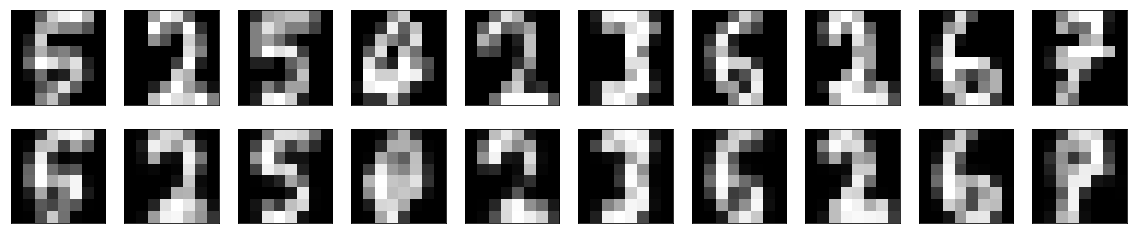

In [196]:
decoded_imgs = autoencoder.predict(x_test)

n = 10
plt.figure(figsize=(20, 4))
for i in range(10):
    ax = plt.subplot(2, n, i + 1)
    plt.imshow(x_test[i].reshape(8, 8))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    ax = plt.subplot(2, n, i + 1 + n)
    plt.imshow(decoded_imgs[i].reshape(8, 8))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()